<a href="https://colab.research.google.com/github/ZachGermain/Asteroid_Clustering/blob/master/Code/Asteroid_Clustering_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import matplotlib.pylab as pl
import numpy as np
import sklearn as skl
from sklearn import preprocessing #sklearn does not automatically import subpackages
from sklearn import manifold
from sklearn import cluster

# **Data Opening and Preprocessing**

In [2]:
astDf = pd.read_csv("https://raw.githubusercontent.com/ZachGermain/DSPS_zgermain/master/EC_Project/asteroidsBelt.csv")
astDf = astDf.set_index('id')
astDf.head()

,a,e,i,spec_B
id,,,,
a0000001,2.769165,0.076009,10.594067,C
a0000002,2.772466,0.230337,34.836234,B
a0000003,2.669150,0.256942,12.988919,Sk
a0000004,2.361418,0.088721,7.141771,V
a0000005,2.574249,0.191095,5.366988,S


In [3]:
astDf.shape

(1256, 4)

In [4]:
astDf.describe()

,a,e,i
count,1256.000000,1256.000000,1256.000000
mean,2.668575,0.142122,8.732625
std,0.299855,0.071539,5.978991
min,1.817514,0.004735,0.264810
25%,2.415790,0.085149,4.625334
50%,2.727534,0.139018,7.455825
75%,2.795298,0.188787,10.967992
max,4.283402,0.598097,38.936411


In [5]:
np.unique(astDf.spec_B)

array(['A', 'B', 'C', 'Cb', 'Cg', 'Cgh', 'Ch', 'D', 'K', 'L', 'Ld', 'O',
       'R', 'S', 'Sa', 'Sk', 'Sl', 'Sq', 'Sr', 'T', 'U', 'V', 'X', 'Xc',
       'Xe', 'Xk'], dtype=object)

In [6]:
for i in np.unique(astDf.spec_B):
  print("{0}: {1}".format(i, list(astDf.spec_B).count(i)))

A: 12
B: 56
C: 139
Cb: 30
Cg: 9
Cgh: 15
Ch: 135
D: 8
K: 31
L: 33
Ld: 11
O: 1
R: 4
S: 348
Sa: 29
Sk: 12
Sl: 47
Sq: 44
Sr: 11
T: 12
U: 1
V: 35
X: 111
Xc: 59
Xe: 24
Xk: 39


## **Data Reduction**

Some data preprocessing: 
  Replacing transitional types with original types.
    Lets similar types be grouped together.
  Getting rid of types with less than 5% of the asteroids of the S-type as these are closer to outliers than clusters.

In [7]:

cTransitions = [ 'Cb', 'Cg', 'Cgh', 'Ch' ]
sTransitions = [ 'Sa', 'Sk', 'Sl', 'Sq', 'Sr' ]
xTransitions  = [ 'Xc', 'Xe', 'Xk' ]
lTransitions = [ 'Ld' ]

for c in cTransitions:
  astDf["spec_B"] = astDf["spec_B"].str.replace(c, 'C')

for s in sTransitions:
  astDf["spec_B"] = astDf["spec_B"].str.replace(s, 'S')

for x in xTransitions:
  astDf["spec_B"] = astDf["spec_B"].str.replace(x, 'X')

for l in lTransitions:
  astDf["spec_B"] = astDf["spec_B"].str.replace(l, 'L')

np.unique(astDf.spec_B)


array(['A', 'B', 'C', 'D', 'K', 'L', 'O', 'R', 'S', 'T', 'U', 'V', 'X'],
      dtype=object)

In [8]:

tinyTypes = [ 'A', 'D', 'O', 'R', 'T', 'U' ]

for t in tinyTypes:
  astDf = astDf[ astDf["spec_B"] != t ]

np.unique(astDf.spec_B)


array(['B', 'C', 'K', 'L', 'S', 'V', 'X'], dtype=object)

In [9]:
for i in np.unique(astDf.spec_B):
  print("{0}: {1}".format(i, list(astDf.spec_B).count(i)))

B: 56
C: 328
K: 31
L: 44
S: 491
V: 35
X: 233


In [10]:
astDf.head()

,a,e,i,spec_B
id,,,,
a0000001,2.769165,0.076009,10.594067,C
a0000002,2.772466,0.230337,34.836234,B
a0000003,2.669150,0.256942,12.988919,S
a0000004,2.361418,0.088721,7.141771,V
a0000005,2.574249,0.191095,5.366988,S


In [11]:
astDf.describe()

,a,e,i
count,1218.000000,1218.000000,1218.000000
mean,2.664952,0.142884,8.695008
std,0.293857,0.071732,5.954243
min,1.817514,0.004735,0.264810
25%,2.414451,0.085559,4.620034
50%,2.726381,0.140029,7.459324
75%,2.793944,0.190248,10.897491
max,4.283402,0.598097,38.936411


The reduction does not seem to have a significant effect on the data distribution.

## **Separate Data into Orbital Parameters and Taxonomy**

In [12]:
taxonomy = astDf[['spec_B']]
taxonomy.head()

,spec_B
id,
a0000001,C
a0000002,B
a0000003,S
a0000004,V
a0000005,S


In [13]:
astDf = astDf.drop(labels = 'spec_B', axis = 1)
astDf.head()

,a,e,i
id,,,
a0000001,2.769165,0.076009,10.594067
a0000002,2.772466,0.230337,34.836234
a0000003,2.669150,0.256942,12.988919
a0000004,2.361418,0.088721,7.141771
a0000005,2.574249,0.191095,5.366988


## **Scaling Data**

In [14]:
astScaled = preprocessing.scale(astDf)
astScaled.mean(0).round(2), astScaled.std(0)

(array([ 0., -0.,  0.]), array([1., 1., 1.]))

# **Data Visualization**

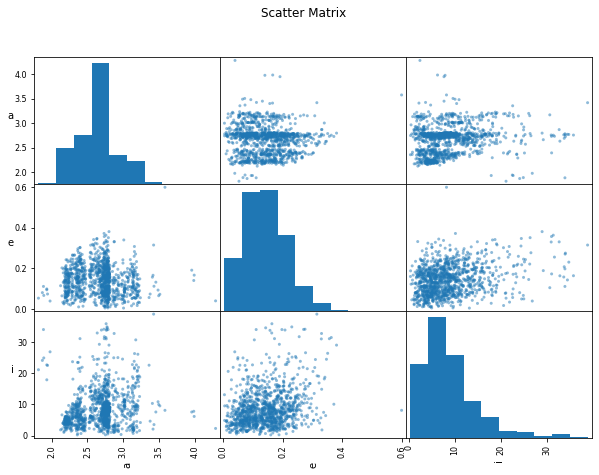

In [15]:
axs = pd.plotting.scatter_matrix(astDf, figsize=(10,7));
for x in range(len(axs)):
    for y in range(len(axs)):
        if x == len(axs) - 1:
            #to make x axis name vertical  
            axs[x, y].xaxis.label.set_rotation(90);
        if y == 0:    
            axs[x, y].yaxis.label.set_rotation(0);
pl.suptitle("Scatter Matrix");

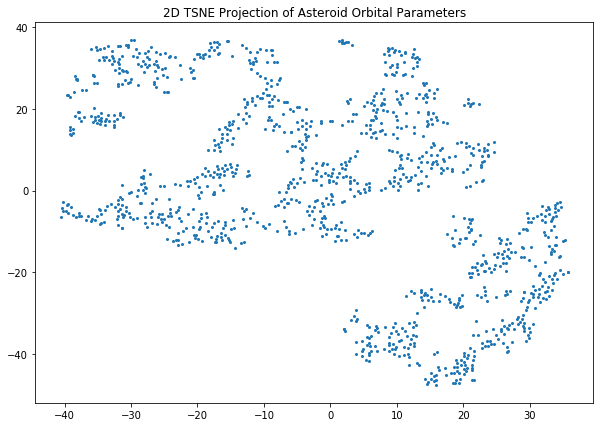

In [16]:
twodproj = manifold.TSNE(random_state = 7).fit_transform(astScaled)
pl.figure(figsize = (10,7))
pl.scatter(twodproj[:,0], twodproj[:,1], s = 4)
pl.title("2D TSNE Projection of Asteroid Orbital Parameters");

# **Clustering**

## **Finding Cluster Centers**

In [17]:
numClusters = len(np.unique(taxonomy.spec_B))
numClusters

7

In [18]:
clusterCenter = np.zeros((numClusters, 3))
clusterTaxonLabels = np.unique(taxonomy.spec_B)

for taxon, clustNum in zip(clusterTaxonLabels, range(0, numClusters)):
  indices = np.flatnonzero(taxonomy['spec_B'] == taxon)
  a = astScaled[indices, 0]
  e = astScaled[indices, 1]
  i = astScaled[indices, 2]
  clusterCenter[clustNum, 0] = a.mean()
  clusterCenter[clustNum, 1] = e.mean()
  clusterCenter[clustNum, 2] = i.mean()

clusterCenter, clusterTaxonLabels

(array([[ 0.28182171,  0.42539131,  0.46805252],
        [ 0.36613307,  0.15410882,  0.0821883 ],
        [ 0.62471205, -0.2275397 ,  0.17526339],
        [ 0.13618196, -0.25535732, -0.04690076],
        [-0.41748233, -0.0475098 , -0.19375695],
        [-1.01345805, -0.5374898 , -0.45343574],
        [ 0.34001336, -0.05983133,  0.23376257]]),
 array(['B', 'C', 'K', 'L', 'S', 'V', 'X'], dtype=object))

Interestingly enough, one can see significant differences of the means between clusters

## **K-Means Clustering Using One Iteration of Centers**

In [19]:
clusteredAst = cluster.KMeans(n_clusters=numClusters, init = clusterCenter).fit(astScaled)

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/k_means_.py:972: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


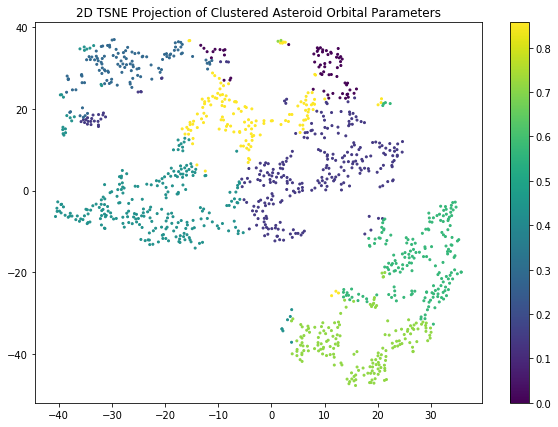

In [20]:
twodproj = manifold.TSNE(random_state = 7).fit_transform(astScaled)
pl.figure(figsize = (10,7))
pl.scatter(twodproj[:,0], twodproj[:,1], c = clusteredAst.labels_/clusteredAst.n_clusters,
           s = 4)
pl.colorbar()
pl.title("2D TSNE Projection of Clustered Asteroid Orbital Parameters");

In [21]:
clusterTaxonCts = np.zeros((numClusters, numClusters))
clusterCts = np.zeros(numClusters)

for clustNum in np.unique(clusteredAst.labels_):
  clusterIndices = np.flatnonzero(clusteredAst.labels_ == clustNum)
  taxons = taxonomy.spec_B[ clusterIndices ]
  clusterCts[clustNum] = taxons.count()
  for taxon, taxonNum in zip(np.unique(taxonomy.spec_B), range(0, numClusters)):
    clusterTaxonCts[clustNum][taxonNum]  = taxons[ taxons == taxon ].count()

print("Order of Taxons:\n", np.unique(taxonomy.spec_B))
print("Taxon Counts per Cluster:\n", clusterTaxonCts)
print("Counts per Cluster:\n", clusterCts)

Order of Taxons:
 ['B' 'C' 'K' 'L' 'S' 'V' 'X']
Taxon Counts per Cluster:
 [[ 12.  17.   2.   1.  14.   0.  18.]
 [ 16. 112.   4.   6.  86.   0.  52.]
 [  3.  45.  16.   3.  11.   0.  40.]
 [  8.  69.   6.  18. 111.   0.  51.]
 [ 11.  31.   0.   6. 115.   8.  13.]
 [  4.  11.   0.   3. 105.  27.  25.]
 [  2.  43.   3.   7.  49.   0.  34.]]
Counts per Cluster:
 [ 64. 276. 118. 263. 184. 175. 138.]


## **K-Means Clustering using n-Iterations**

Order of Taxons:
 ['B' 'C' 'K' 'L' 'S' 'V' 'X']
Taxon Counts per Cluster:
 [[  2.  12.   1.   4.  92.  26.  27.]
 [  6.  68.   5.   6.  57.   0.  37.]
 [  7.  63.   8.  17. 102.   0.  46.]
 [ 13.  28.   1.   3. 122.   9.  14.]
 [ 15.  91.   1.   6.  79.   0.  40.]
 [  2.  54.  14.   8.  25.   0.  57.]
 [ 11.  12.   1.   0.  14.   0.  12.]]
Counts per Cluster:
 [164. 179. 243. 190. 232. 160.  50.]


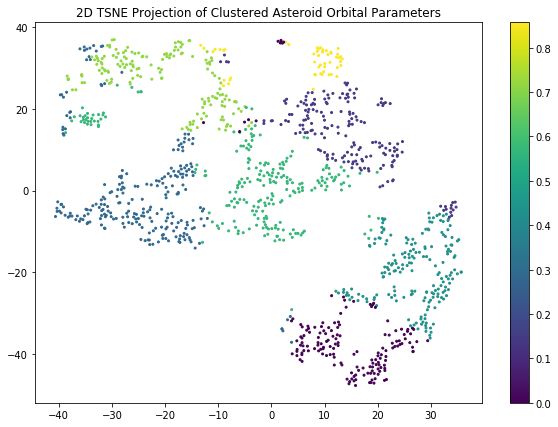

In [22]:
nIter = 10; #1000 iterations has similar numerical results 

clusteredAst2 = cluster.KMeans(n_clusters=numClusters, n_init = nIter, random_state = 17).fit(astScaled)

twodproj2 = manifold.TSNE(random_state = 7).fit_transform(astScaled)
pl.figure(figsize = (10,7))
pl.scatter(twodproj[:,0], twodproj[:,1], c = clusteredAst2.labels_/clusteredAst2.n_clusters,
           s = 4)
pl.colorbar()
pl.title("2D TSNE Projection of Clustered Asteroid Orbital Parameters");

clusterTaxonCts2 = np.zeros((numClusters, numClusters))
clusterCts2 = np.zeros(numClusters)

for clustNum in np.unique(clusteredAst2.labels_):
  clusterIndices2 = np.flatnonzero(clusteredAst2.labels_ == clustNum)
  taxons2 = taxonomy.spec_B[ clusterIndices2 ]
  clusterCts2[clustNum] = taxons2.count()
  for taxon, taxonNum in zip(np.unique(taxonomy.spec_B), range(0, numClusters)):
    clusterTaxonCts2[clustNum][taxonNum]  = taxons2[ taxons2 == taxon ].count()

print("Order of Taxons:\n", np.unique(taxonomy.spec_B))
print("Taxon Counts per Cluster:\n", clusterTaxonCts2)
print("Counts per Cluster:\n", clusterCts2)

# **Cluster Analysis**

Using clustering based on center points

## **Purity Per Cluster**

In [23]:
totPurityArr = np.zeros(numClusters)
for taxon, taxonNum in zip(np.unique(taxonomy.spec_B), range(0, numClusters)):
  totPurityArr[taxonNum] = (taxonomy.spec_B[taxonomy.spec_B == taxon]).count()/taxonomy.spec_B.count()

for taxon, taxonNum in zip(np.unique(taxonomy.spec_B), range(0, numClusters)):
  print("{0}: {1:.3f}".format(np.unique(taxonomy.spec_B)[taxonNum], totPurityArr[taxonNum]))

B: 0.046
C: 0.269
K: 0.025
L: 0.036
S: 0.403
V: 0.029
X: 0.191


In [33]:
purityArr = np.zeros((numClusters, numClusters))
for clusterNum in range(0, numClusters):
  print("For Cluster {0}:".format(clusterNum + 1))
  for taxon, taxonNum in zip(np.unique(taxonomy.spec_B), range(0, numClusters)):
    purityArr[clusterNum][taxonNum] = (clusterTaxonCts[clusterNum][taxonNum])/clusterCts[clusterNum]
    print("{0}: {1:.3f}".format(taxon, purityArr[clusterNum][taxonNum]))
  print("")

For Cluster 1:
B: 0.188
C: 0.266
K: 0.031
L: 0.016
S: 0.219
V: 0.000
X: 0.281

For Cluster 2:
B: 0.058
C: 0.406
K: 0.014
L: 0.022
S: 0.312
V: 0.000
X: 0.188

For Cluster 3:
B: 0.025
C: 0.381
K: 0.136
L: 0.025
S: 0.093
V: 0.000
X: 0.339

For Cluster 4:
B: 0.030
C: 0.262
K: 0.023
L: 0.068
S: 0.422
V: 0.000
X: 0.194

For Cluster 5:
B: 0.060
C: 0.168
K: 0.000
L: 0.033
S: 0.625
V: 0.043
X: 0.071

For Cluster 6:
B: 0.023
C: 0.063
K: 0.000
L: 0.017
S: 0.600
V: 0.154
X: 0.143

For Cluster 7:
B: 0.014
C: 0.312
K: 0.022
L: 0.051
S: 0.355
V: 0.000
X: 0.246



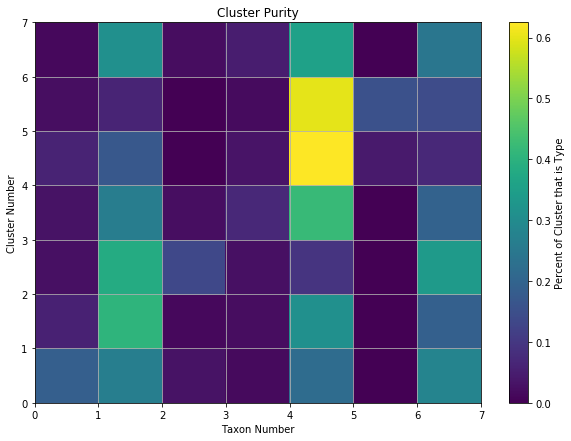

In [38]:
ax = pl.figure(figsize = (10, 7))
pl.pcolor(purityArr, vmin = 0, vmax = np.max(purityArr))
pl.title("Cluster Purity")
pl.colorbar(label = "Percent of Cluster that is Type")
pl.xlabel("Taxon Number")
pl.ylabel("Cluster Number")
pl.grid();

In [0]:
for i in range(0, numClusters):
  sumNum = 0
  for j in range(0, numClusters):
    sumNum+=purityArr[i,j];
  print(sumNum)

1.0
1.0
1.0
1.0
1.0
1.0
1.0


## **Distribution of Taxonomic Types**

In [26]:
taxonArr = np.zeros((numClusters, numClusters))
for taxon, taxonNum in zip(np.unique(taxonomy.spec_B), range(0, numClusters)):
  print("For {0}:".format(taxon))
  for clusterNum in range(0, numClusters):
    taxonArr[taxonNum][clusterNum] = (clusterTaxonCts[clusterNum][taxonNum])/taxonomy.spec_B[taxonomy.spec_B == taxon].count()
    print("Cluster {0}: {1:.3f}".format(clusterNum + 1, taxonArr[taxonNum][clusterNum]))
  print("")

For B:
Cluster 1: 0.214
Cluster 2: 0.286
Cluster 3: 0.054
Cluster 4: 0.143
Cluster 5: 0.196
Cluster 6: 0.071
Cluster 7: 0.036

For C:
Cluster 1: 0.052
Cluster 2: 0.341
Cluster 3: 0.137
Cluster 4: 0.210
Cluster 5: 0.095
Cluster 6: 0.034
Cluster 7: 0.131

For K:
Cluster 1: 0.065
Cluster 2: 0.129
Cluster 3: 0.516
Cluster 4: 0.194
Cluster 5: 0.000
Cluster 6: 0.000
Cluster 7: 0.097

For L:
Cluster 1: 0.023
Cluster 2: 0.136
Cluster 3: 0.068
Cluster 4: 0.409
Cluster 5: 0.136
Cluster 6: 0.068
Cluster 7: 0.159

For S:
Cluster 1: 0.029
Cluster 2: 0.175
Cluster 3: 0.022
Cluster 4: 0.226
Cluster 5: 0.234
Cluster 6: 0.214
Cluster 7: 0.100

For V:
Cluster 1: 0.000
Cluster 2: 0.000
Cluster 3: 0.000
Cluster 4: 0.000
Cluster 5: 0.229
Cluster 6: 0.771
Cluster 7: 0.000

For X:
Cluster 1: 0.077
Cluster 2: 0.223
Cluster 3: 0.172
Cluster 4: 0.219
Cluster 5: 0.056
Cluster 6: 0.107
Cluster 7: 0.146



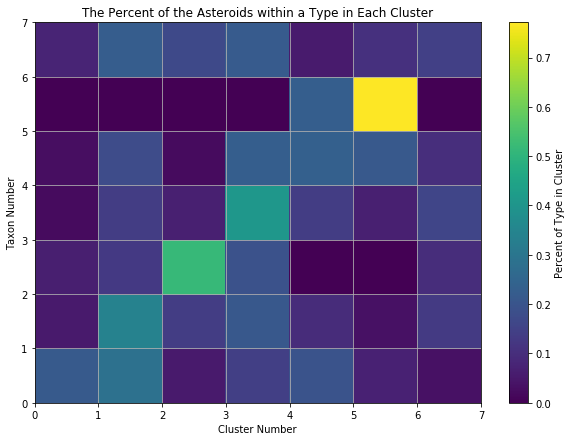

In [36]:
ax = pl.figure(figsize = (10, 7))
pl.pcolor(taxonArr, vmin = 0, vmax = np.max(taxonArr))
pl.title("The Percent of the Asteroids within a Type in Each Cluster")
pl.colorbar(label = "Percent of Type in Cluster")
pl.xlabel("Cluster Number")
pl.ylabel("Taxon Number")
pl.grid();